In [2]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

anthrax_data = genfromtxt('anthrax.csv', delimiter=',') #in the form of [t, S, I, A, C]

torch.manual_seed(1234)

In [3]:
%%time

PATH = 'anthrax' 

class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, A_data, C_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.A = torch.tensor(A_data)
        self.C = torch.tensor(C_data)

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to

        #learnable parameters
        self.r_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/300)
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/600)
        self.kappa_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/10)
        self.eta_a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/2)
        self.eta_c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/10)
        self.eta_i_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/100)
        self.tao_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/10)
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/7)
        self.delta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/64)
        self.K_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(100)
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/500)
        self.sigma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/10)

        #matrices (x4 for S, I, A, C) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

        #values for norm
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.A_max = max(self.A)
        self.C_max = max(self.C)
        
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.A_min = min(self.A)
        self.C_min = min(self.C)

        #normalize 
        self.S_hat = (self.S - self.S_min)/(self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min)/(self.I_max - self.I_min)
        self.A_hat = (self.A - self.A_min)/(self.A_max - self.A_min)
        self.C_hat = (self.C - self.C_min)/(self.C_max - self.C_min)

        #NN
        self.net_anthrax = self.Net_anthrax()
        self.params = list(self.net_anthrax.parameters())
        self.params.extend(list([self.r_tilda, self.mu_tilda, self.kappa_tilda, self.eta_a_tilda, self.eta_c_tilda, self.eta_i_tilda, self.tao_tilda, self.gamma_tilda, self.delta_tilda, self.K_tilda, self.beta_tilda, self.sigma_tilda]))


    #force parameters to be in a range

    @property
    def r(self):
        return torch.tanh(self.r_tilda) * 0.0003 + 0.0033

    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) * 0.0002 + 0.0016
        
    @property
    def kappa(self):
        return torch.tanh(self.kappa_tilda) * 0.01 + 0.1
        
    @property
    def eta_a(self):
        return torch.tanh(self.eta_a_tilda) * 0.01 + 0.5
        
    @property
    def eta_c(self):
        return torch.tanh(self.eta_c_tilda) * 0.01 + 0.1
        
    @property
    def eta_i(self):
        return torch.tanh(self.eta_i_tilda) * 0.001 + 0.01
        
    @property
    def tao(self):
        return torch.tanh(self.tao_tilda) * 0.01 + 0.1
        
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) * 0.01 + 0.14
        
    @property
    def delta(self):
        return torch.tanh(self.delta_tilda) * 0.002 + 0.05
        
    @property
    def K(self):
        return torch.tanh(self.K_tilda) * 2 + 100
        
    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) * 0.0002 + 0.002
        
    @property
    def sigma(self):
        return torch.tanh(self.sigma_tilda) * 0.01 + 0.1
        

    #nets
    class Net_anthrax(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_anthrax, self).__init__()
            self.fc1=nn.Linear(1, 64) #takes 100 t's
            self.fc2=nn.Linear(64, 64)
            self.fc3=nn.Linear(64, 64)
            self.fc4=nn.Linear(64, 64)
            self.fc5=nn.Linear(64, 64)
            self.fc6=nn.Linear(64, 64)
            self.fc7=nn.Linear(64, 64)
            self.fc8=nn.Linear(64, 64)
            self.out=nn.Linear(64, 4) #outputs S, I, A, C

        def forward(self, t):
            anthrax=F.relu(self.fc1(t))
            anthrax=F.relu(self.fc2(anthrax))
            anthrax=F.relu(self.fc3(anthrax))
            anthrax=F.relu(self.fc4(anthrax))
            anthrax=F.relu(self.fc5(anthrax))
            anthrax=F.relu(self.fc6(anthrax))
            anthrax=F.relu(self.fc7(anthrax))
            anthrax=F.relu(self.fc8(anthrax))
            anthrax=self.out(anthrax)
            return anthrax    

    def net_f(self, t_batch):       

        anthrax_hat = self.net_anthrax(t_batch)

        S_hat, I_hat, A_hat, C_hat = anthrax_hat[:,0], anthrax_hat[:,1], anthrax_hat[:,2], anthrax_hat[:,3]

        #S_hat
        anthrax_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_hat
        anthrax_hat.backward(self.m2, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #A_hat
        anthrax_hat.backward(self.m3, retain_graph=True)
        A_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #C_hat
        anthrax_hat.backward(self.m4, retain_graph=True)
        C_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        A = self.A_min + (self.A_max - self.A_min) * A_hat
        C = self.C_min + (self.C_max - self.C_min) * C_hat
     
        #equations
        f1_hat = S_hat_t - (self.r * (S + I) * (1 - (S + I)/self.K) - self.eta_a * A * S - self.eta_c * S * C - self.eta_i * (S * I)/(S + I) - self.mu * S + self.tao * I) / (self.S_max - self.S_min) 
        f2_hat = I_hat_t - (self.eta_a * A * S + self.eta_c * S * C + (self.eta_i * (S * I)/(S + I) - (self.gamma + self.mu + self.tao)) * I) / (self.I_max - self.I_min) 
        f3_hat = A_hat_t - (-self.sigma * A + self.beta * C) / (self.A_max - self.A_min) 
        f4_hat = C_hat_t - ((self.gamma + self.mu) * I - self.delta * (S + I) * C - self.kappa * C) / (self.C_max - self.C_min) 

        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, A_hat, C_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        I_pred_list = []
        A_pred_list = []
        C_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, S_hat_pred, I_hat_pred, A_hat_pred, C_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_hat_pred)
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_hat_pred)
        A_pred_list.append(self.A_min + (self.A_max - self.A_min) * A_hat_pred)
        C_pred_list.append(self.C_min + (self.C_max - self.C_min) * C_hat_pred)

        loss = (
              torch.mean(torch.square(self.S_hat - S_hat_pred)) + torch.mean(torch.square(self.I_hat - I_hat_pred)) + 
              torch.mean(torch.square(self.A_hat - A_hat_pred)) + torch.mean(torch.square(self.C_hat - C_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat))
               )

        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        #self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 9999:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return S_pred_list, I_pred_list, A_pred_list, C_pred_list

CPU times: user 76 µs, sys: 2 µs, total: 78 µs
Wall time: 81.3 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0136, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0
CPU times: user 11.6 s, sys: 2.16 s, total: 13.8 s
Wall time: 14.1 s


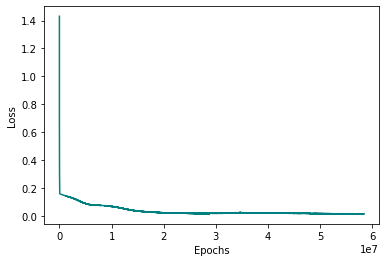

In [4]:
%%time

#this worked best
dinn = DINN(anthrax_data[0], anthrax_data[1], anthrax_data[2], anthrax_data[3], anthrax_data[4])

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.99, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-8, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.95, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list, I_pred_list, A_pred_list, C_pred_list = dinn.train(1) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, I_pred_list, A_pred_list, C_pred_list = dinn.train(1) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, I_pred_list, A_pred_list, C_pred_list = dinn.train(1) #train

Text(0, 0.5, 'Loss')

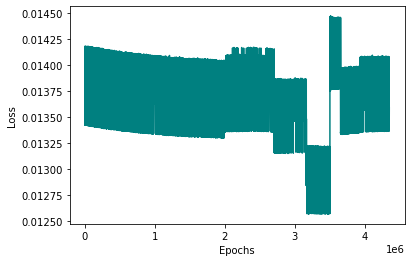

In [5]:
plt.plot(dinn.losses[54000000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

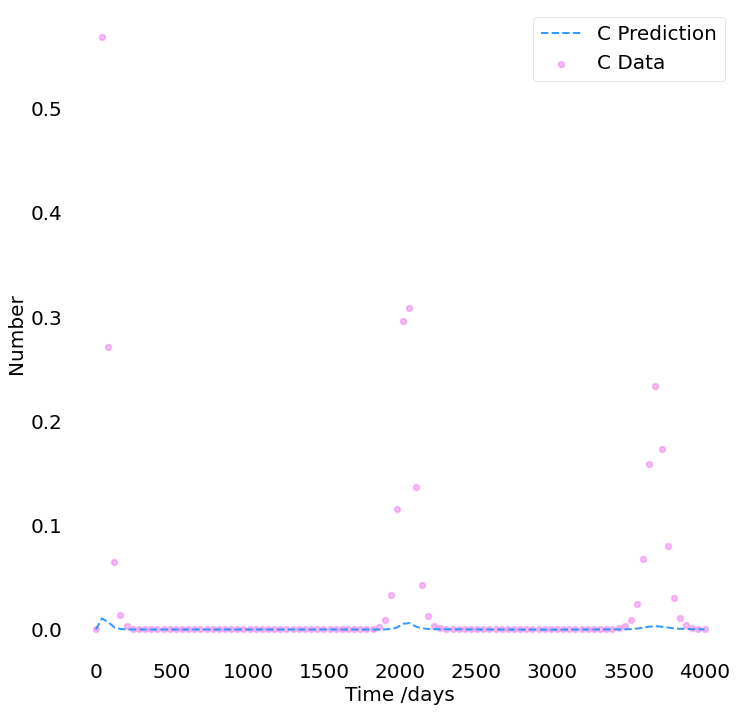

In [13]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

# ax.scatter(anthrax_data[0], anthrax_data[1], color = 'pink', alpha=0.5, lw=2, label='S Data', s=30)
# ax.plot(anthrax_data[0], S_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='S Prediction', linestyle='dashed')

# ax.scatter(anthrax_data[0], anthrax_data[2], color = 'darkgreen', alpha=0.5, lw=2, label='I Data', s=30)
# ax.plot(anthrax_data[0], I_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='I Prediction', linestyle='dashed')

# ax.scatter(anthrax_data[0], anthrax_data[3], color = 'blue', alpha=0.5, lw=2, label='A Data', s=30)
# ax.plot(anthrax_data[0], A_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='A Prediction', linestyle='dashed')

ax.scatter(anthrax_data[0], anthrax_data[4], color = 'violet', alpha=0.5, lw=2, label='C Data', s=30)
ax.plot(anthrax_data[0], A_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='C Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
# ax.grid(b=True, which='major', c='black', lw=0.2, ls=30')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('anthrax_c.png')
plt.show()

tensor([0.0034], grad_fn=<AddBackward0>)
tensor([0.0017], grad_fn=<AddBackward0>)
tensor([0.1025], grad_fn=<AddBackward0>)
tensor([0.5035], grad_fn=<AddBackward0>)
tensor([0.1024], grad_fn=<AddBackward0>)
tensor([0.0106], grad_fn=<AddBackward0>)
tensor([0.0976], grad_fn=<AddBackward0>)
tensor([0.1444], grad_fn=<AddBackward0>)
tensor([0.0512], grad_fn=<AddBackward0>)
tensor([100.6391], grad_fn=<AddBackward0>)
tensor([0.0021], grad_fn=<AddBackward0>)
tensor([0.1051], grad_fn=<AddBackward0>)


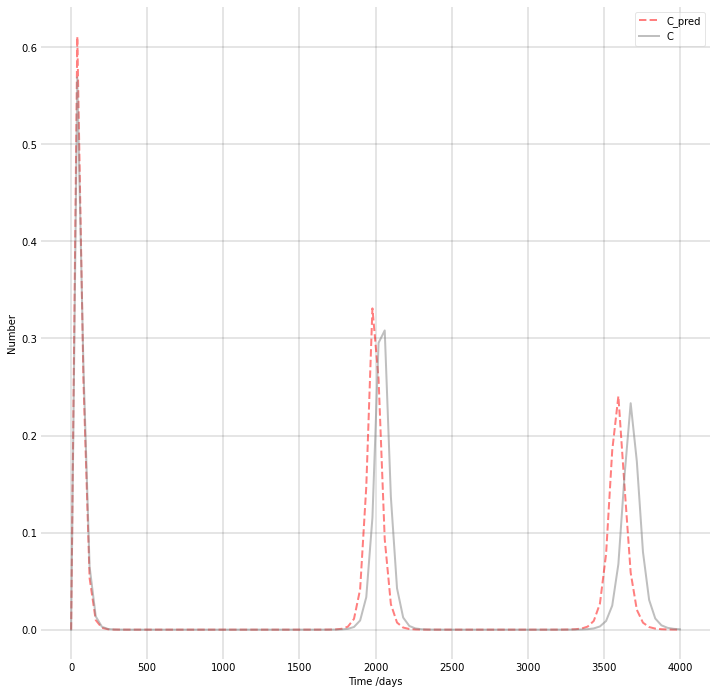

In [7]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions

S0 = 20
I0 = 3
A0 = 0
C0 = 0

# A grid of time points (in days)
t = np.linspace(0, 4000, 100) 

#parameters
r = dinn.r
mu = dinn.mu
kappa = dinn.kappa
eta_a = dinn.eta_a
eta_c = dinn.eta_c
eta_i = dinn.eta_i
tao = dinn.tao
gamma = dinn.gamma
delta = dinn.delta
K = dinn.K
beta = dinn.beta
sigma = dinn.sigma


print(dinn.r)
print(dinn.mu)
print(dinn.kappa)
print(dinn.eta_a)
print(dinn.eta_c)
print(dinn.eta_i)
print(dinn.tao)
print(dinn.gamma)
print(dinn.delta)
print(dinn.K)
print(dinn.beta)
print(dinn.sigma)

# The SIR model differential equations.
def deriv(y, t, r ,mu ,kappa ,eta_a ,eta_c ,eta_i ,tao ,gamma ,delta ,K ,beta ,sigma ):
    S, I, A, C = y

    dSdt = r * (S + I) * (1 - (S + I)/K) - eta_a * A * S - eta_c * S * C - eta_i * (S * I)/(S + I) - mu * S + tao * I
    dIdt = eta_a * A * S + eta_c * S * C + (eta_i * (S * I)/(S + I) - (gamma + mu + tao)) * I
    dAdt = -sigma * A + beta * C
    dCdt = (gamma + mu) * I - delta * (S + I) * C - kappa * C
    
    return dSdt, dIdt, dAdt, dCdt


# Initial conditions vector
y0 = S0, I0, A0, C0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(r ,mu ,kappa ,eta_a ,eta_c ,eta_i ,tao ,gamma ,delta ,K ,beta ,sigma ))
S, I, A, C = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

# ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Sh_pred', linestyle='dashed')
# ax.plot(anthrax_data[0], anthrax_data[1], 'black', alpha=0.5, lw=2, label='S')

# ax.plot(t, I, 'blue', alpha=0.5, lw=2, label='I_pred', linestyle='dashed')
# ax.plot(anthrax_data[0], anthrax_data[2], 'darkgreen', alpha=0.5, lw=2, label='I')

# ax.plot(t, A, 'orange', alpha=0.5, lw=2, label='A_pred', linestyle='dashed')
# ax.plot(anthrax_data[0], anthrax_data[3], 'purple', alpha=0.5, lw=2, label='A')

ax.plot(t, C, 'red', alpha=0.5, lw=2, label='C_pred', linestyle='dashed')
ax.plot(anthrax_data[0], anthrax_data[4], 'grey', alpha=0.5, lw=2, label='C')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [8]:
S_total_loss = 0
S_den = 0
I_total_loss = 0
I_den = 0
A_total_loss = 0
A_den = 0
C_total_loss = 0
C_den = 0

for timestep in range(len(t)):
    S_value = anthrax_data[1][timestep] - S[timestep]
    S_total_loss += S_value**2
    S_den += (anthrax_data[1][timestep])**2

    I_value = anthrax_data[2][timestep] - I[timestep]
    I_total_loss += I_value**2
    I_den += (anthrax_data[2][timestep])**2
    
    A_value = anthrax_data[3][timestep] - A[timestep]
    A_total_loss += A_value**2
    A_den += (anthrax_data[3][timestep])**2
    
    C_value = anthrax_data[4][timestep] - C[timestep]
    C_total_loss += C_value**2
    C_den += (anthrax_data[4][timestep])**2
    

S_total_loss = math.sqrt(S_total_loss/S_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
A_total_loss = math.sqrt(A_total_loss/A_den)
C_total_loss = math.sqrt(C_total_loss/C_den)

print('S_total_loss', S_total_loss)
print('I_total_loss', I_total_loss)
print('A_total_loss', A_total_loss)
print('C_total_loss', C_total_loss)

S_total_loss 0.20138812612661824
I_total_loss 0.4476721151278991
A_total_loss 0.5646649467402258
C_total_loss 0.5749614857605271
